In [163]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from albatross.analysis import plot_windrose, boxplot
from sklearn.ensemble import RandomForestRegressor
# from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

In [164]:
cmap = mpl.colormaps['tab10']

In [165]:
# DATA_DIRS = ['../data/Kelmarsh_SCADA_2020/', '../data/Kelmarsh/SCADA_2021']

# FNAMES = [
#     "Turbine_Data_Kelmarsh_1_2020-01-01_-_2021-01-01_228.csv",
    # "Turbine_Data_Kelmarsh_2_2020-01-01_-_2021-01-01_229.csv",
    # "Turbine_Data_Kelmarsh_3_2020-01-01_-_2021-01-01_230.csv",
    # "Turbine_Data_Kelmarsh_4_2020-01-01_-_2021-01-01_231.csv",
    # "Turbine_Data_Kelmarsh_5_2020-01-01_-_2021-01-01_232.csv",
    # "Turbine_Data_Kelmarsh_6_2020-01-01_-_2021-01-01_233.csv",
# ]

# turbines = []

# for i, _ in enumerate(FNAMES):
#     fname = DATA_DIR + FNAMES[i]
#     print(f"Loading data: {FNAMES[i]}")
#     wt = pd.read_csv(fname, header=9)
#     turbines.append(wt)

wt_2020 = pd.read_csv("../data/Kelmarsh_SCADA_2020/Turbine_Data_Kelmarsh_1_2020-01-01_-_2021-01-01_228.csv", header=9)
wt_2021 = pd.read_csv("../data/Kelmarsh_SCADA_2021/Turbine_Data_Kelmarsh_1_2021-01-01_-_2021-07-01_228.csv", header=9)

wt_raw = pd.concat([wt_2020, wt_2021])

In [166]:
wt_raw.columns[wt_raw.columns.str.contains("power")]

Index(['Potential power default PC (kW)', 'Potential power learned PC (kW)',
       'Potential power reference turbines (kW)',
       'Cascading potential power (kW)',
       'Cascading potential power for performance (kW)',
       'Potential power met mast anemometer (kW)',
       'Potential power primary reference turbines (kW)',
       'Potential power secondary reference turbines (kW)',
       'Potential power estimated (kW)', 'Potential power MPC (kW)',
       'Potential power met mast anemometer MPC (kW)', 'Reactive power (kvar)',
       'Reactive power, Max (kvar)', 'Reactive power, Min (kvar)',
       'Reactive power, Standard deviation (kvar)', 'Apparent power (kVA)',
       'Apparent power, Max (kVA)', 'Apparent power, Min (kVA)',
       'Apparent power, StdDev (kVA)'],
      dtype='object')

In [167]:
wt = wt_raw.loc[:, ["# Date and time", "Power (kW)", "Wind direction (°)", "Wind speed (m/s)"]]
wt = wt.rename(columns={"# Date and time": "Date", "Power (kW)": "Power", "Wind direction (°)": "Wind direction", "Wind speed (m/s)": "Wind speed"})
wt["Date"] = pd.to_datetime(wt["Date"].astype("datetime64"))
wt = wt.set_index("Date")
wt = wt.asfreq("10min")

wt["Power"].bfill(inplace=True)
wt["Wind direction"].bfill(inplace=True)
wt["Wind speed"].bfill(inplace=True)
# wt["Power"] = wt["Power"].transform(lambda p: max(p, 0))
wt = wt.sort_index()

wt.head()

,Power,Wind direction,Wind speed
Date,,,
2020-01-01 00:00:00,150.984141,116.839462,3.887291
2020-01-01 00:10:00,130.414782,115.659361,3.848941
2020-01-01 00:20:00,146.401656,116.646515,4.043625
2020-01-01 00:30:00,84.296224,111.157642,3.330342
2020-01-01 00:40:00,94.994105,116.678227,3.388536


In [168]:
sum(wt["Power"].transform(lambda x: x < 0))

9416

In [169]:
(wt.index == pd.date_range(start=wt.index.min(),
                             end=wt.index.max(),
                             freq=wt.index.freq)).all()


True

In [170]:
wt.describe()

,Power,Wind direction,Wind speed
count,78768.000000,78768.000000,78768.000000
mean,668.380546,191.587540,6.268384
std,674.642507,95.832166,3.003321
min,-17.010895,0.012631,0.229894
25%,106.344393,107.742304,4.046222
50%,413.350342,212.901421,5.919835
75%,1095.469194,259.274312,8.033695
max,2078.528772,359.990140,22.419562


In [171]:
len(wt[wt["Power"].isnull()])

0

In [172]:
speed = wt.loc[:, "Wind speed"]
direction = wt.loc[:, "Wind direction"]
active_power = wt.loc[:, "Power"]

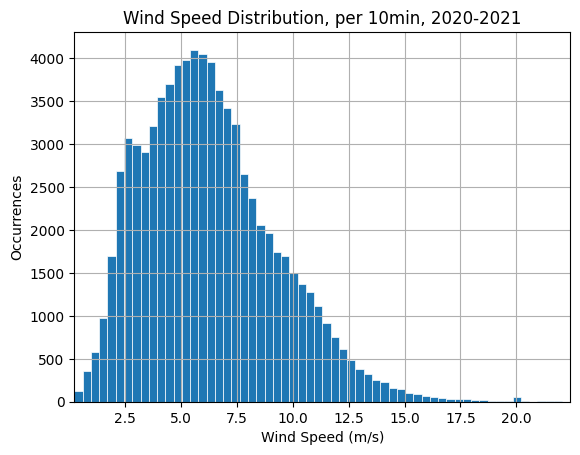

In [173]:
fig, ax = plt.subplots()

ax.set_title("Wind Speed Distribution, per 10min, 2020-2021")
ax.set_xlabel("Wind Speed (m/s)")
ax.set_ylabel("Occurrences")
ax.set_xmargin(0)
ax.hist(speed, 60, linewidth=0.5, edgecolor="white")
ax.grid(True)

<WindroseAxes:>

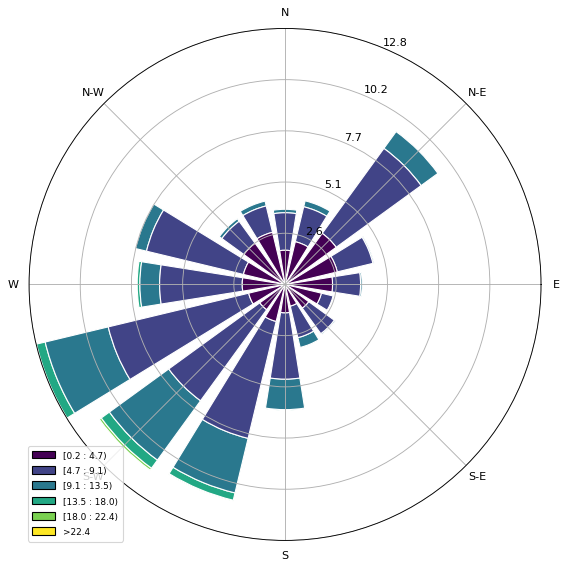

In [174]:
plot_windrose(wt, speed="Wind speed", direction="Wind direction")

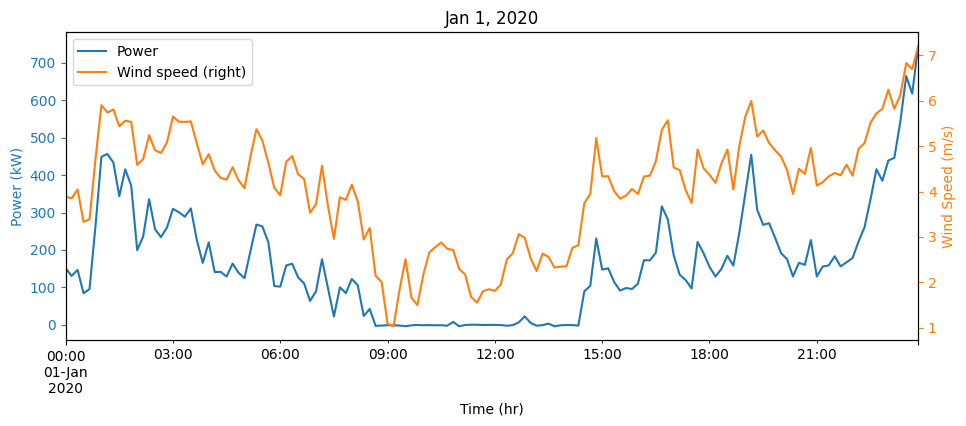

In [175]:
# wt_h = wt.resample(rule='H', closed='left', label ='right').mean()

wt_1day = wt.loc[(wt.index >= "2020-01-01") & (wt.index < "2020-01-02")]

# time_1d = (wt_1day.index - wt_1day.index[0]).total_seconds() / 60

fig, ax1 = plt.subplots(figsize=(11, 4))

wt_1day[["Power", "Wind speed"]].plot(secondary_y="Wind speed", ax=ax1)

ax1.set_title("Jan 1, 2020")
ax1.set_ylabel("Power (kW)")
ax1.set_xmargin(0)
ax1.set_xlabel("Time (hr)")
ax1.tick_params(axis='y', colors=cmap.colors[0])
ax1.yaxis.label.set_color(cmap.colors[0])
ax1.right_ax.set_ylabel("Wind Speed (m/s)")
ax1.right_ax.yaxis.label.set_color(cmap.colors[1])
ax1.right_ax.tick_params(axis='y', colors=cmap.colors[1])

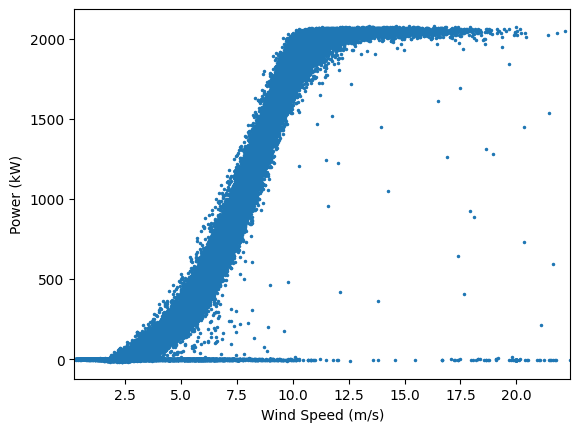

In [176]:
ax = plt.subplot()
ax.plot(speed, active_power, "o", markersize=1.5)
ax.set_xlabel("Wind Speed (m/s)")
ax.set_ylabel("Power (kW)")
ax.set_xmargin(0)

In [177]:
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.plot_trisurf(direction, speed, active_power)

In [178]:
data = wt["Power"]

data.head(12)

Date
2020-01-01 00:00:00    150.984141
2020-01-01 00:10:00    130.414782
2020-01-01 00:20:00    146.401656
2020-01-01 00:30:00     84.296224
2020-01-01 00:40:00     94.994105
2020-01-01 00:50:00    262.992229
2020-01-01 01:00:00    449.115810
2020-01-01 01:10:00    456.427864
2020-01-01 01:20:00    433.714243
2020-01-01 01:30:00    343.683160
2020-01-01 01:40:00    415.606102
2020-01-01 01:50:00    371.579486
Freq: 10T, Name: Power, dtype: float64

In [179]:
period = wt.index.to_series().asfreq("H")[1:]

LAG = 6

X = np.zeros((len(period), 6))
y = np.zeros(len(period))

current = LAG

for i, row in enumerate(X):
    X[i, :] = data[current-LAG:current]
    y[i] = data[current]
    current += LAG

columns = [f"p_{i}0" for i in range(LAG)]

X = pd.DataFrame(X, index=period, columns=columns)
y = pd.Series(y, index=period)

X.head(2)

,p_00,p_10,p_20,p_30,p_40,p_50
Date,,,,,,
2020-01-01 01:00:00,150.984141,130.414782,146.401656,84.296224,94.994105,262.992229
2020-01-01 02:00:00,449.115810,456.427864,433.714243,343.683160,415.606102,371.579486


In [180]:
np.array_equal(X.iloc[0, :], data[:6])

True

In [181]:
X_train = X[X.index < "2021-01-01"]
X_test = X[(X.index >= "2021-01-01")] #& (X.index < "2021-01-02")]
y_train = y[y.index < "2021-01-01"]
y_test = y[(X.index >= "2021-01-01")] #& (X.index < "2021-01-02")]

In [182]:
X_train

,p_00,p_10,p_20,p_30,p_40,p_50
Date,,,,,,
2020-01-01 01:00:00,150.984141,130.414782,146.401656,84.296224,94.994105,262.992229
2020-01-01 02:00:00,449.115810,456.427864,433.714243,343.683160,415.606102,371.579486
2020-01-01 03:00:00,199.209134,235.702883,335.663537,255.108857,234.261773,260.194224
2020-01-01 04:00:00,309.811697,300.722514,288.692892,310.927899,226.487825,165.236907
2020-01-01 05:00:00,220.213718,140.731781,141.257295,128.816916,163.406377,138.845655
...,...,...,...,...,...,...
2020-12-31 19:00:00,-1.936605,-2.980131,-1.698131,-1.315078,-2.602413,-1.058998
2020-12-31 20:00:00,-0.898414,-1.724806,-0.690181,-1.285735,-1.892325,-1.327882
2020-12-31 21:00:00,-1.136889,-1.818702,-1.271864,-1.142224,-2.314323,-1.609036


In [183]:
X_test

,p_00,p_10,p_20,p_30,p_40,p_50
Date,,,,,,
2021-01-01 00:00:00,-1.348688,-3.748371,-2.761930,-2.240700,-4.011920,-2.042772
2021-01-01 01:00:00,-1.338018,-2.593343,-1.319346,-1.118750,-2.800342,-1.663453
2021-01-01 02:00:00,-2.163046,-2.196420,-1.368961,-1.245723,-2.407686,-0.985375
2021-01-01 03:00:00,-2.008206,-2.523455,-1.264929,-1.369495,-2.246569,-2.463170
2021-01-01 04:00:00,-2.349911,-1.993156,-1.611170,-1.322013,-2.816880,-1.947809
...,...,...,...,...,...,...
2021-06-30 19:00:00,-1.000000,-1.830000,-1.920000,-0.550000,-1.470000,-4.110000
2021-06-30 20:00:00,-0.970000,-0.910000,-0.170000,-0.940000,-0.110000,-0.120000
2021-06-30 21:00:00,-0.590000,-0.260000,-0.620000,-0.660000,-1.110000,-0.280000


In [184]:
rf = RandomForestRegressor(n_estimators=500, oob_score=True)
rf

RandomForestRegressor(n_estimators=500, oob_score=True)

In [185]:
rf.fit(X_train, y_train)

rf.oob_score_

0.9437977229213753

In [186]:
rf.score(X_test, y_test)

0.9456741571512497

In [187]:
predictions = pd.Series(rf.predict(X_test), index=X_test.index)
predictions

Date
2021-01-01 00:00:00    0.350372
2021-01-01 01:00:00    0.201348
2021-01-01 02:00:00   -1.484962
2021-01-01 03:00:00   -0.278229
2021-01-01 04:00:00    2.369474
                         ...   
2021-06-30 19:00:00   -0.211880
2021-06-30 20:00:00   -0.829532
2021-06-30 21:00:00   -0.417624
2021-06-30 22:00:00   -0.390441
2021-06-30 23:00:00   -0.869368
Length: 4344, dtype: float64

In [188]:
mean_squared_error(y_true=y_test, y_pred=predictions, squared=False)

152.29233820177828

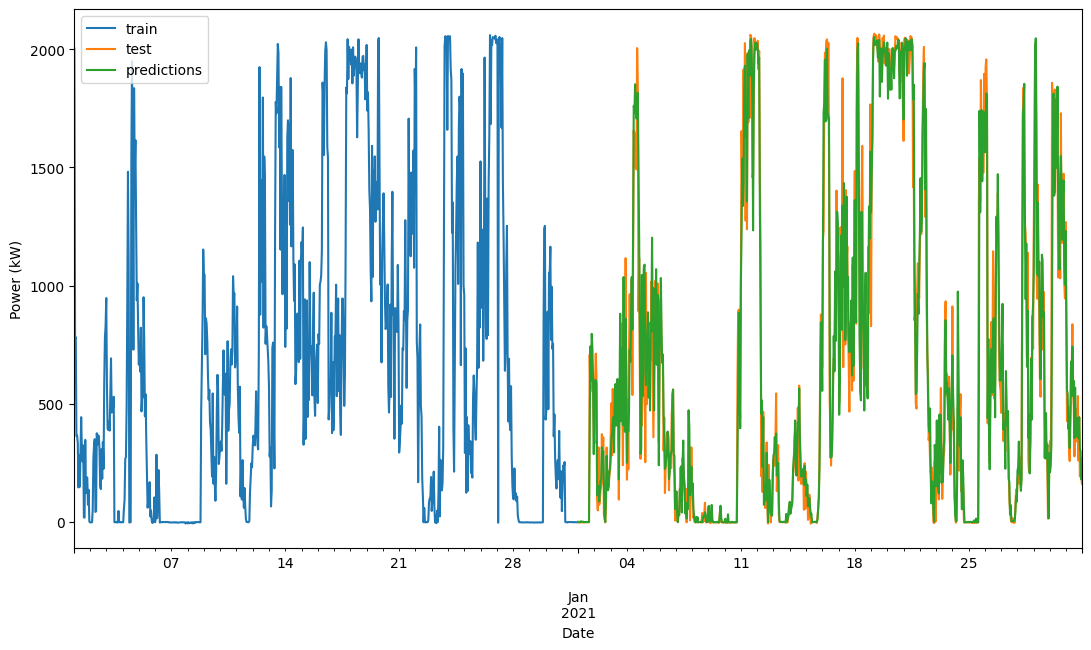

In [189]:
fig, ax = plt.subplots(figsize=(13, 7))
y_train[(y_train.index > "12-01-2020") & (y_train.index <= "02-01-2021")].plot(ax=ax, label="train")
y_test[y_test.index < "02-01-2021"].plot(ax=ax, label="test")
predictions[predictions.index < "02-01-2021"].plot(ax=ax, label="predictions")
ax.set_ylabel("Power (kW)")
ax.legend();